# **DBSCAN CLUSTERING**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid


In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"

In [4]:
df0 = pd.read_csv(url)

In [5]:
df0.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
df0.describe(include = "all")

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [7]:
df0.shape

(440, 8)

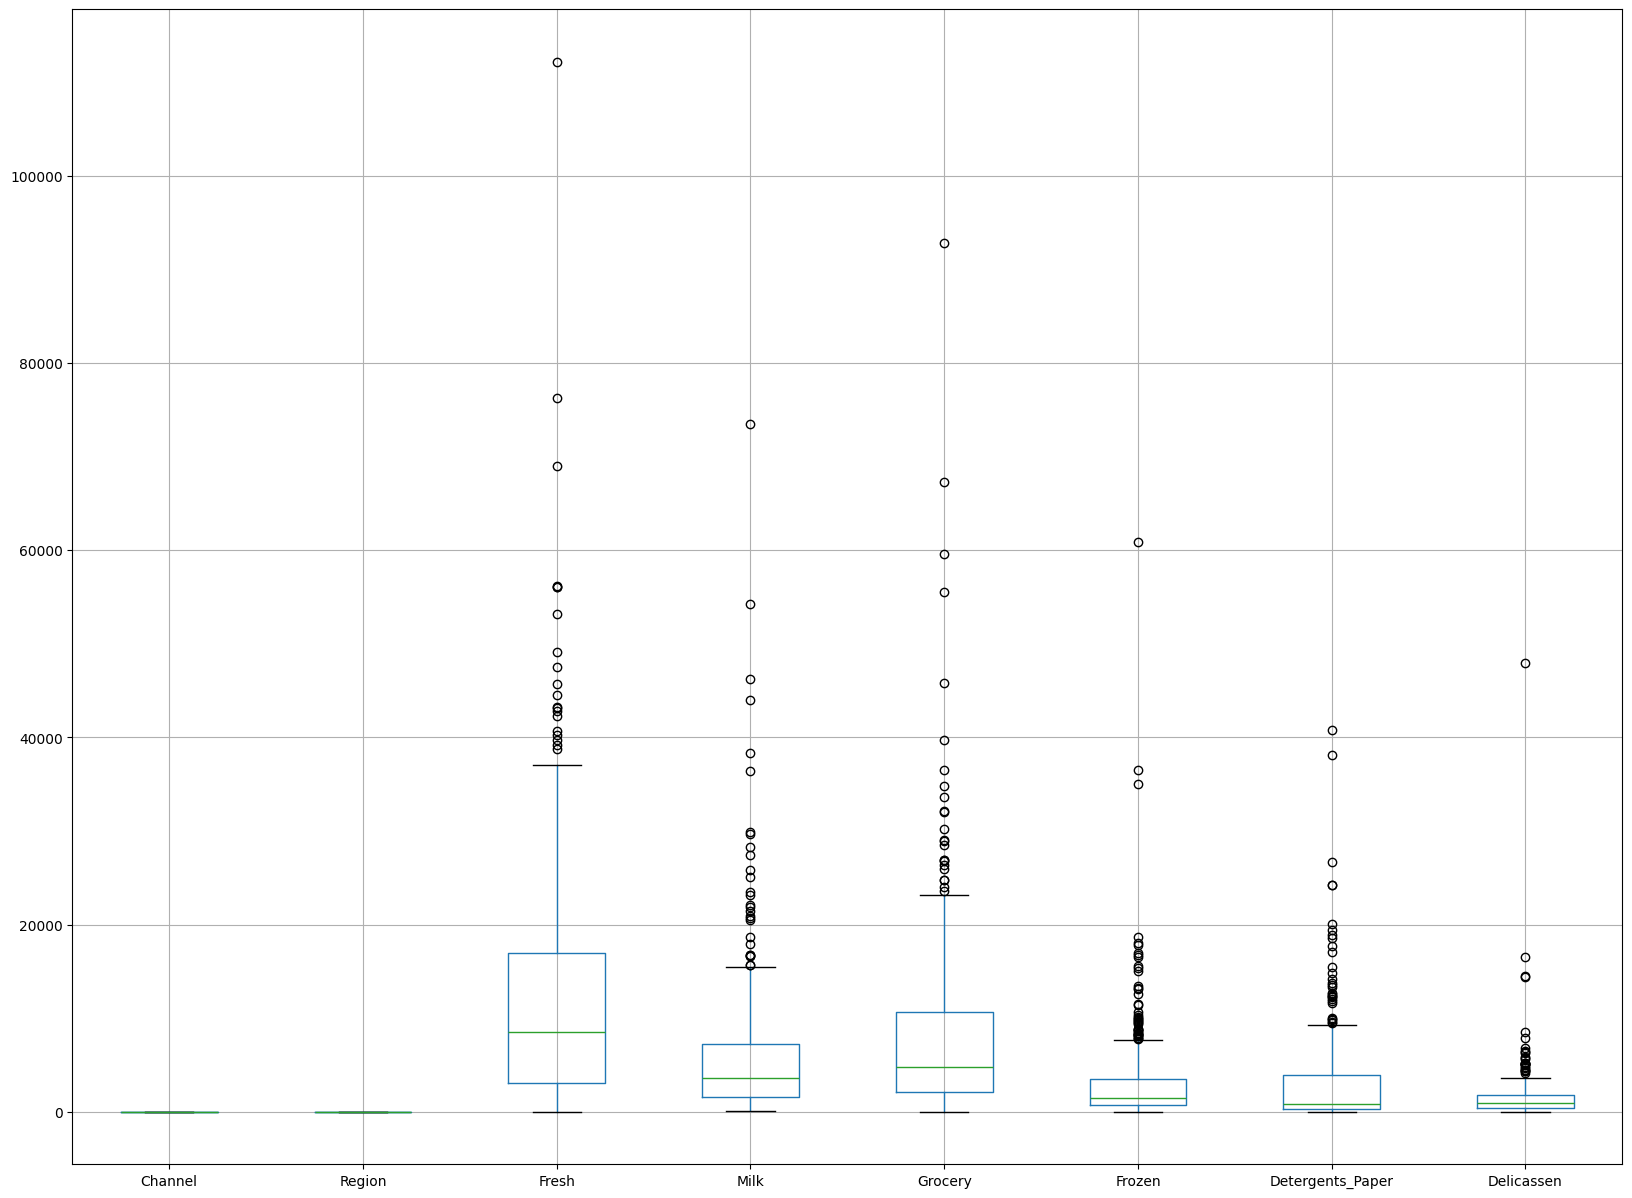

In [9]:
df0.boxplot(figsize=(20,15))
plt.show()

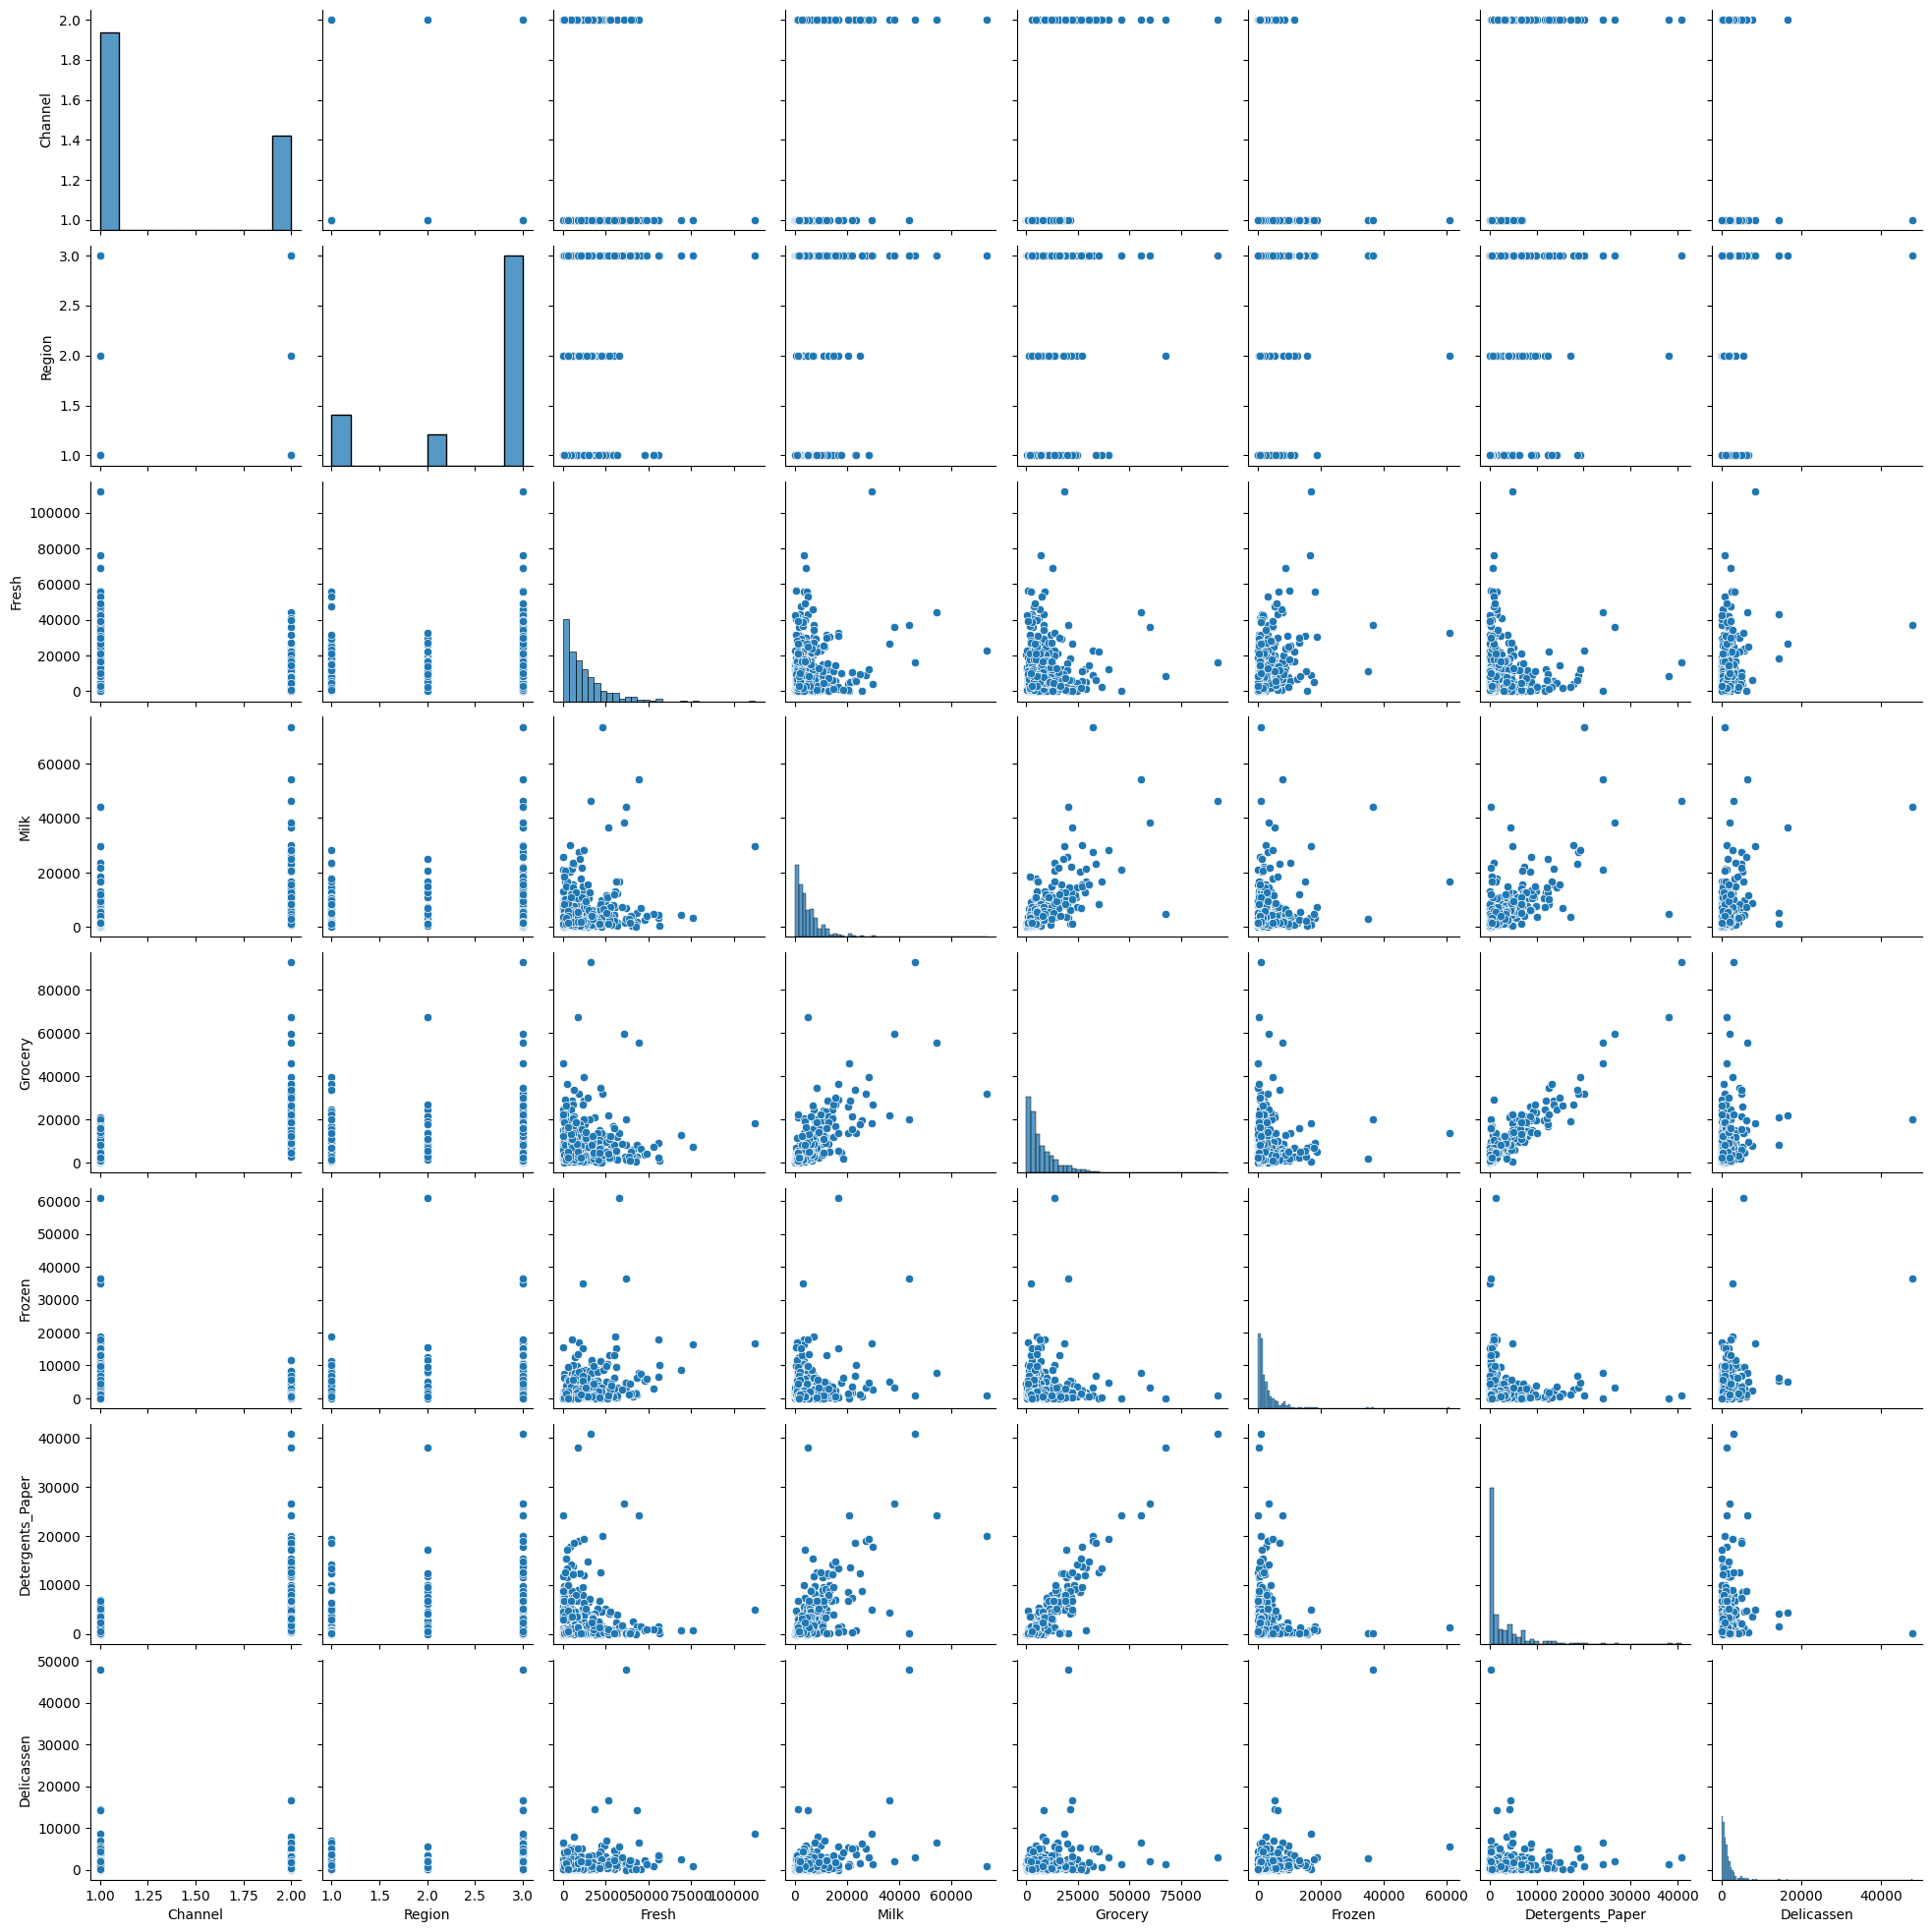

In [10]:
sns.pairplot(df0)
plt.show()

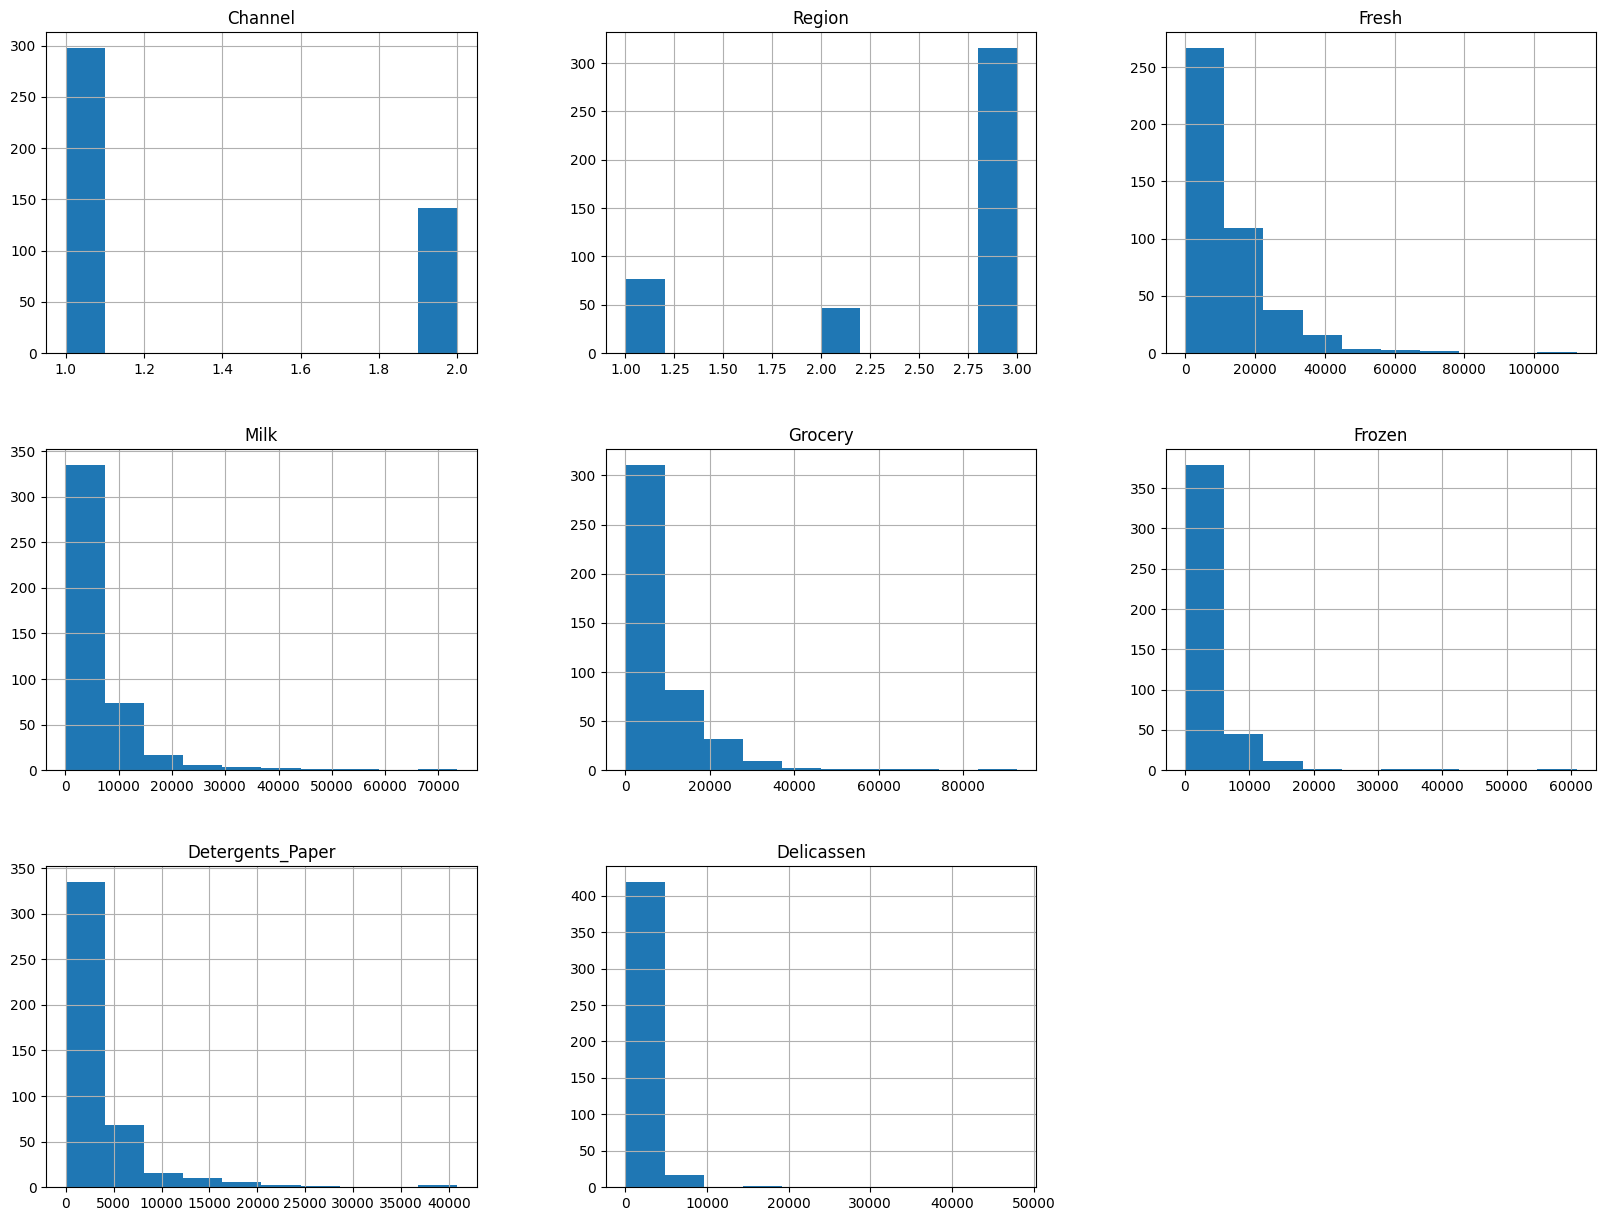

In [11]:
df0.hist(figsize=(20,15))
plt.show()

In [15]:
#data transformation
pt = PowerTransformer()
x_pt = pd.DataFrame(pt.fit_transform(df0.iloc[:,2:]), columns = df0.columns[2:])
x_transf = pd.concat([df0.iloc[:,:2], x_pt], axis = 1)
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(x_transf) , columns = x_transf.columns)
X.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


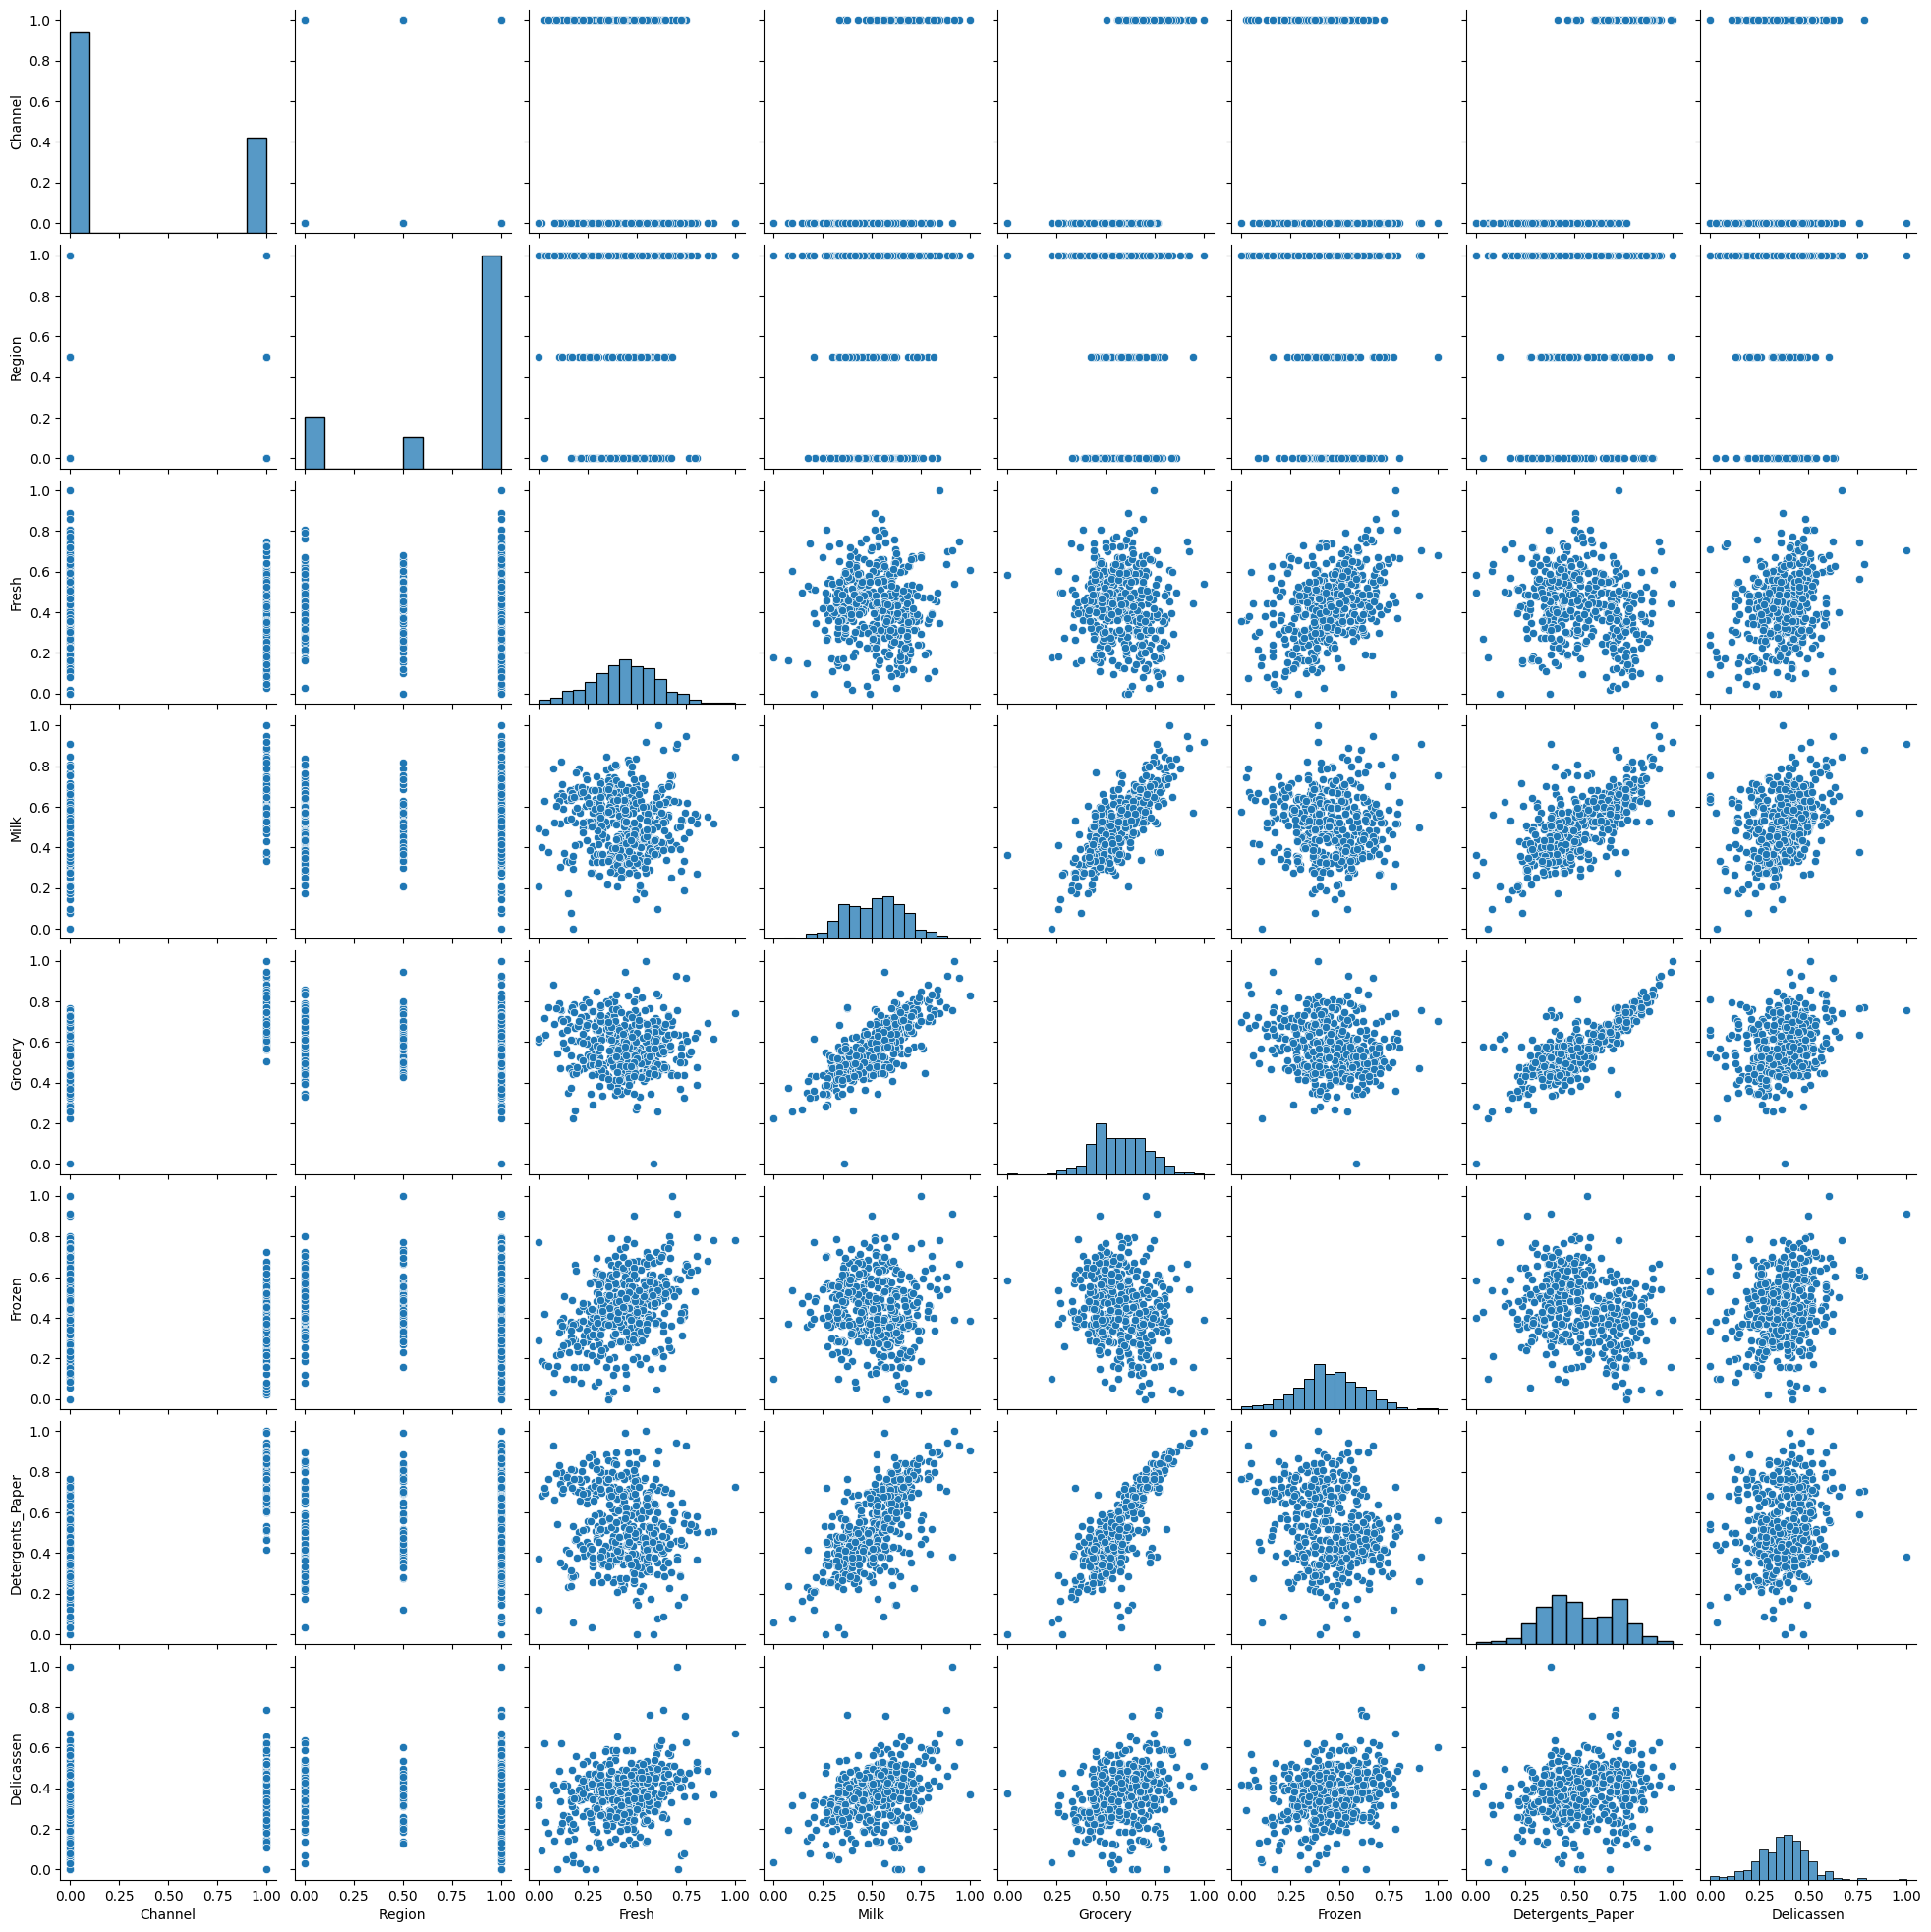

In [16]:
sns.pairplot(X)
plt.show()

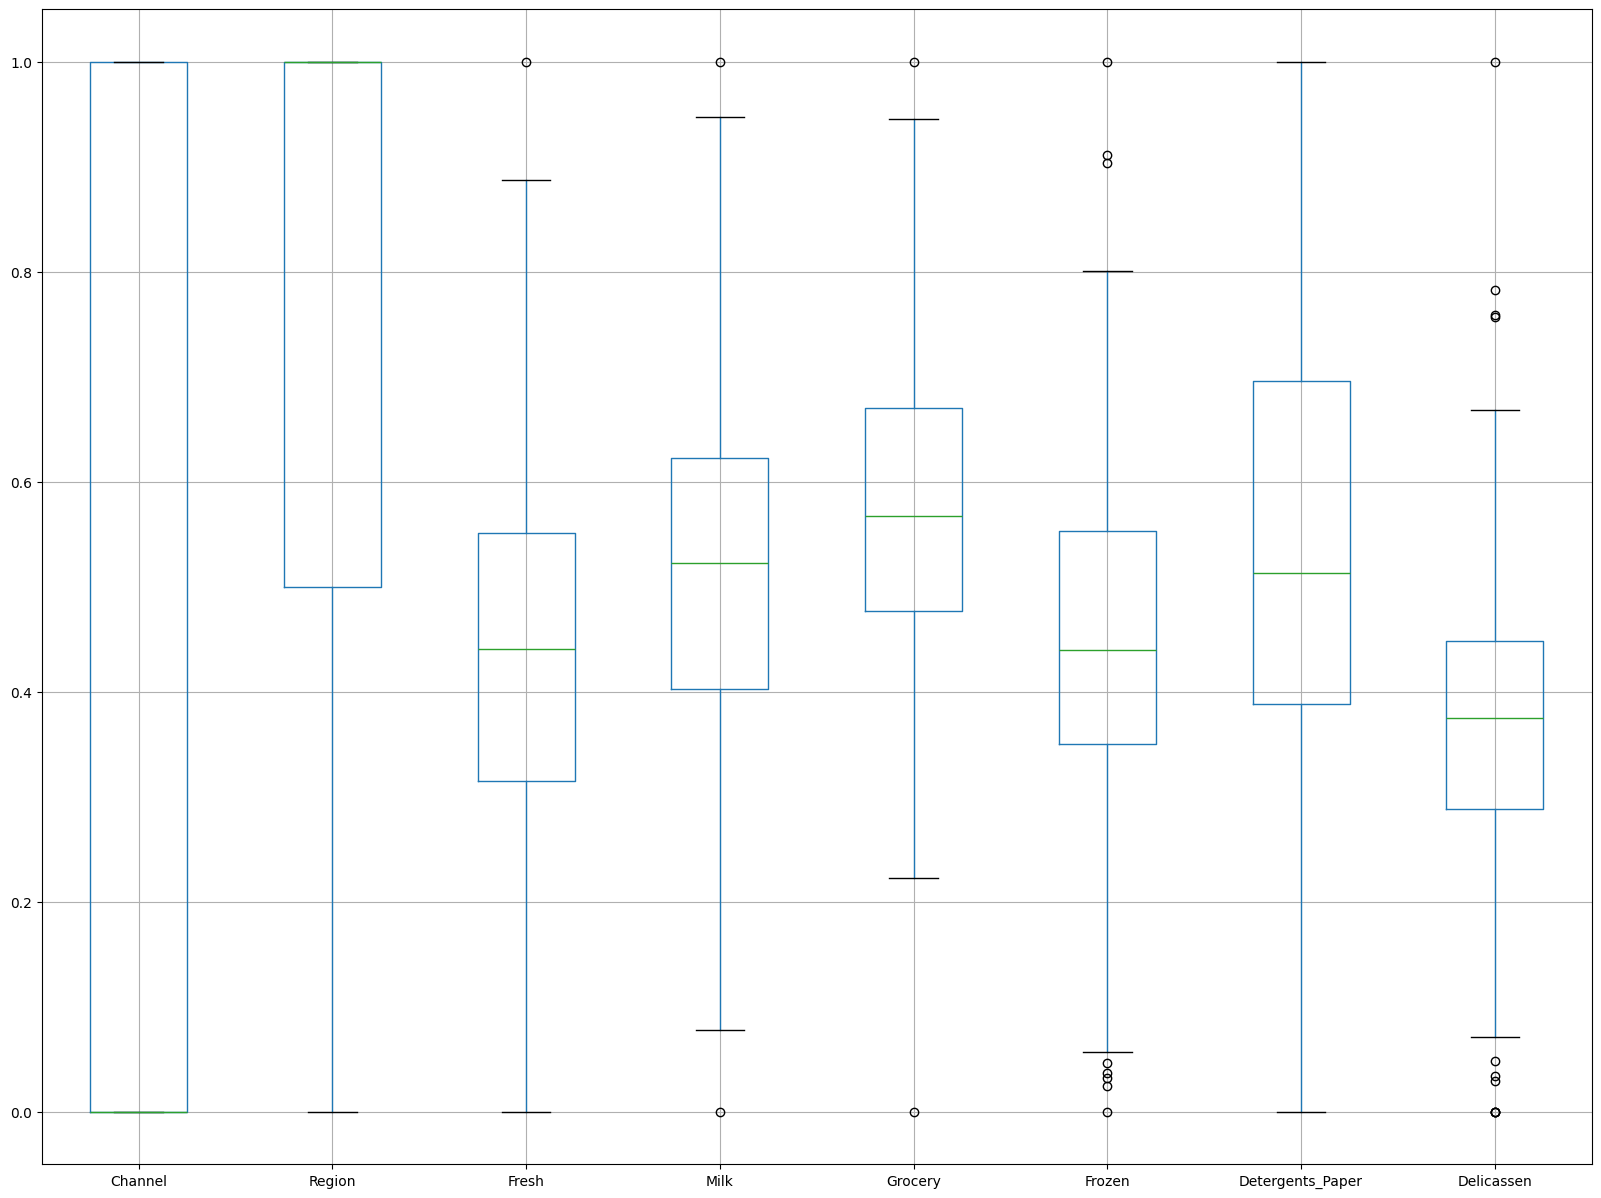

In [17]:
X.boxplot(figsize=(20,15))
plt.show()

DBSCAN has 2 main hyperparameters:

Other notes:

Points not in any cluster are labeled -1 (noise).

Works well for non-spherical clusters and varying densities.

Does not require the number of clusters in advance.
| Parameter     | Meaning                                                        |
| ------------- | -------------------------------------------------------------- |
| `eps`         | Maximum distance between two points to be considered neighbors |
| `min_samples` | Minimum number of points to form a dense region (cluster)      |


In [20]:
db = DBSCAN()
y_db = db.fit_predict(X)
print("the default eps and min_samples params are" , db.eps , "and" , db.min_samples)

the default eps and min_samples params are 0.5 and 5


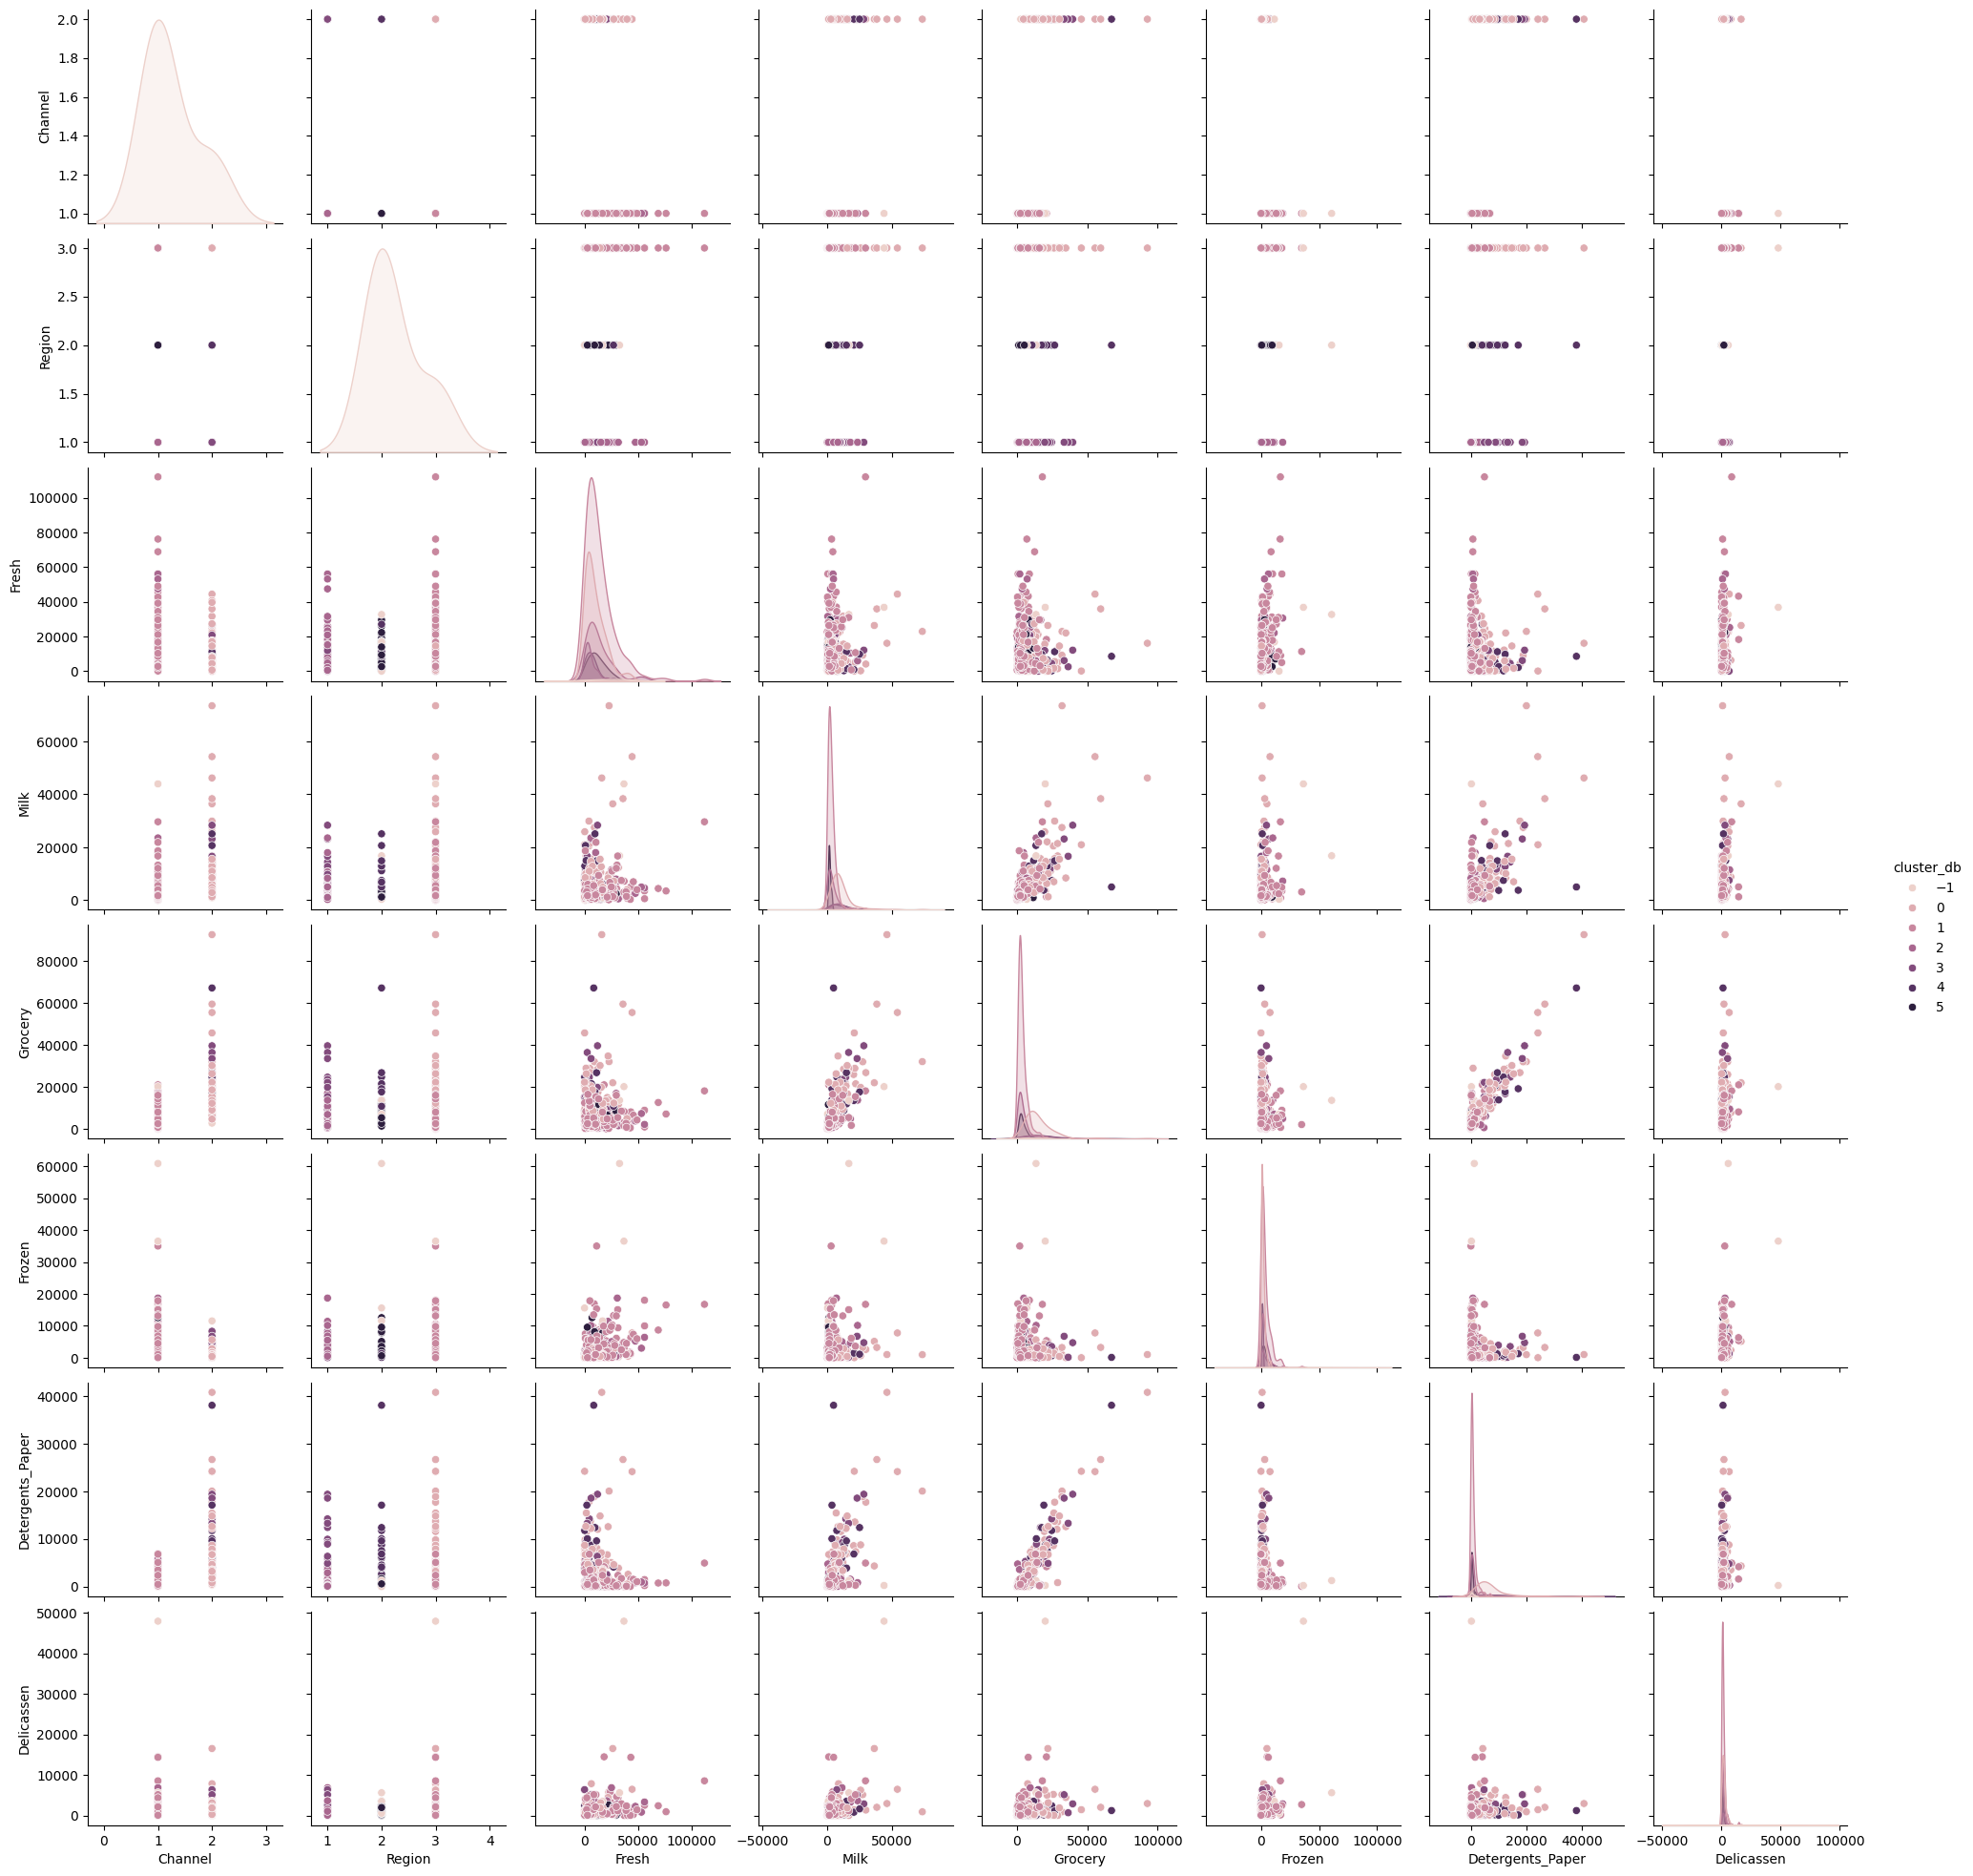

In [25]:
sns.pairplot(df0, hue='cluster_db')
plt.show()

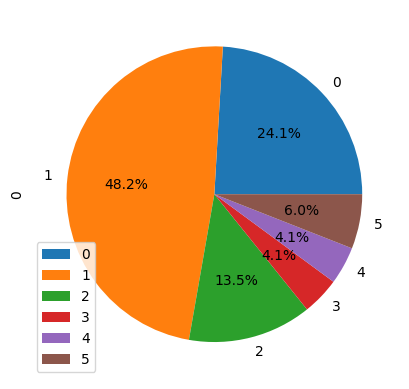

In [29]:
clust_size_db = np.unique(y_db[y_db!=-1]  , return_counts=True)
pd.DataFrame(clust_size_db[1]).plot.pie(y=0, autopct='%1.1f%%', );
plt.show()

Explore DBSCAN hyperparameters


We use ParameterGrid to test multiple combinations:

In [64]:
param_grid = {'eps' : list(np.arange(0.001,1,0.005)) # from 0.001 to 1 in steps of 0.005
 , 'min_samples' : list(range(2,10,1)  )# from 2 to 9
 }

In [65]:
params = list (ParameterGrid(param_grid))

In [66]:
#Prepare a dataframe to store results
dbscan_out = pd.DataFrame(columns = ['eps' , 'min_samples' , 'n_clusters' , 'sil' , 'unclust%'])


| Column        | Meaning                                                             |
| ------------- | ------------------------------------------------------------------- |
| `eps`         | the eps used in that run                                            |
| `min_samples` | the min_samples used in that run                                    |
| `n_clusters`  | number of clusters found (excluding noise)                          |
| `silhouette`  | silhouette score of the clustered points (measure of quality)       |
| `unclust%`    | percentage of points **not assigned** to any cluster (labeled `-1`) |

np.unique(y_db) → gets all unique cluster labels (including -1 for noise).

cluster_labels_all != -1 → removes the noise label.

n_clusters → number of real clusters found by DBSCAN.

This ensures we only count actual clusters, ignoring noise points.

We only consider valid DBSCAN outputs:

n_clusters > 1: at least 2 clusters (otherwise meaningless).

n_clusters < len(y_db): DBSCAN hasn’t assigned each point to its own cluster (otherwise meaningless).

This avoids storing results where DBSCAN failed completely.

In [67]:
#loop over all params combinations
for i in range(len(params)):
  db = DBSCAN(**(params[i]))
  y_db = db.fit_predict(X)
  #Compute number of clusters (excluding noise)
  cluster_labels_all = np.unique(y_db)
  cluster_labels = cluster_labels_all[cluster_labels_all!=-1]
  n_clusters = len(cluster_labels)
  #Avoid trivial solutions
  if 1 < n_clusters < len(y_db):
    #Compute silhouette score
    X_cl = X[y_db != -1]
    y_db_cl = y_db[y_db != -1]
    sil = silhouette_score(X_cl, y_db_cl)
    #Compute percentage of unclustered points
    uncl_p = (1-y_db_cl.shape[0] / y_db.shape[0] ) * 100
    # Store results in dataframe
    dbscan_out.loc[len(dbscan_out)] = [db.eps , db.min_samples , n_clusters , sil , uncl_p] #len(dbscan_out) → current row index (append at end).

Explanation:

sil_thr = 0.5

Silhouette score ranges from -1 to 1.

> 0.5 is usually considered good separation between clusters.

We only want parameter combinations that produce well-separated clusters.

unc_thr = 10

unclust% is the percentage of points that DBSCAN labeled as noise (-1).

We want most points assigned to clusters, so less than 10% noise is acceptable.

High unclust% means DBSCAN is too strict (small eps) and many points are considered outliers.

n_clu_max_thr = 5

To make the clustering interpretable and comparable to KMeans/Agglomerative (we saw 3-4 clusters there).

Avoid parameter settings that produce too many tiny clusters.
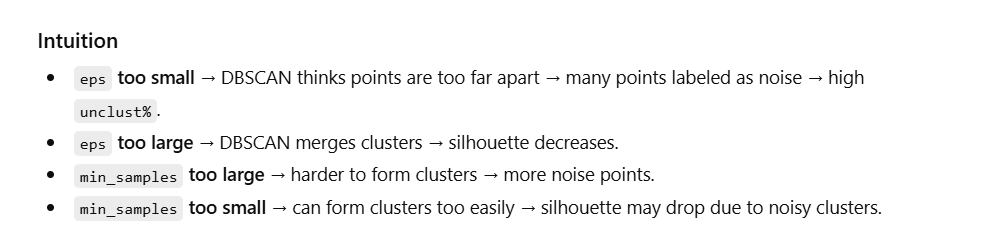

In [68]:
#Define thresholds
sil_thr = 0.5   # silhouette score > 0.5
unc_thr = 10    # less than 10% points unclustered
n_clu_max_thr = 5  # at most 5 clusters


In [74]:
#filter the result
dbscan_out[
    (dbscan_out['sil'] >= sil_thr) &
    (dbscan_out['unclust%'] <= unc_thr) &
    (dbscan_out['n_clusters'] <= n_clu_max_thr)
].sort_values(['sil' , 'unclust%'] , ascending = [False, True])

,eps,min_samples,n_clusters,sil,unclust%
652,0.506,2.0,4.0,0.529010,0.909091
653,0.506,3.0,4.0,0.529010,0.909091
654,0.506,4.0,4.0,0.529010,0.909091
655,0.506,5.0,4.0,0.529010,0.909091
656,0.506,6.0,4.0,0.529010,0.909091
...,...,...,...,...,...
743,0.561,5.0,2.0,0.500188,0.227273
744,0.561,6.0,2.0,0.500188,0.227273
745,0.561,7.0,2.0,0.500188,0.227273
746,0.561,8.0,2.0,0.500188,0.227273


In [77]:
#Choose best parameters
best = {'eps' : 0.506 , 'min_samples' : 2}
db = DBSCAN(**best)
y_db = db.fit_predict(X)

In [95]:
best_row = dbscan_out.loc[dbscan_out['sil'].idxmax()]
print(
    "Best number of clusters:", int(best_row['n_clusters']),
    "\nBest silhouette score:", round(best_row['sil'], 3),
    "\nBest eps:", best_row['eps'],
    "\nBest min_samples:", int(best_row['min_samples'])
)




Best number of clusters: 2 
Best silhouette score: 0.913 
Best eps: 0.091 
Best min_samples: 4


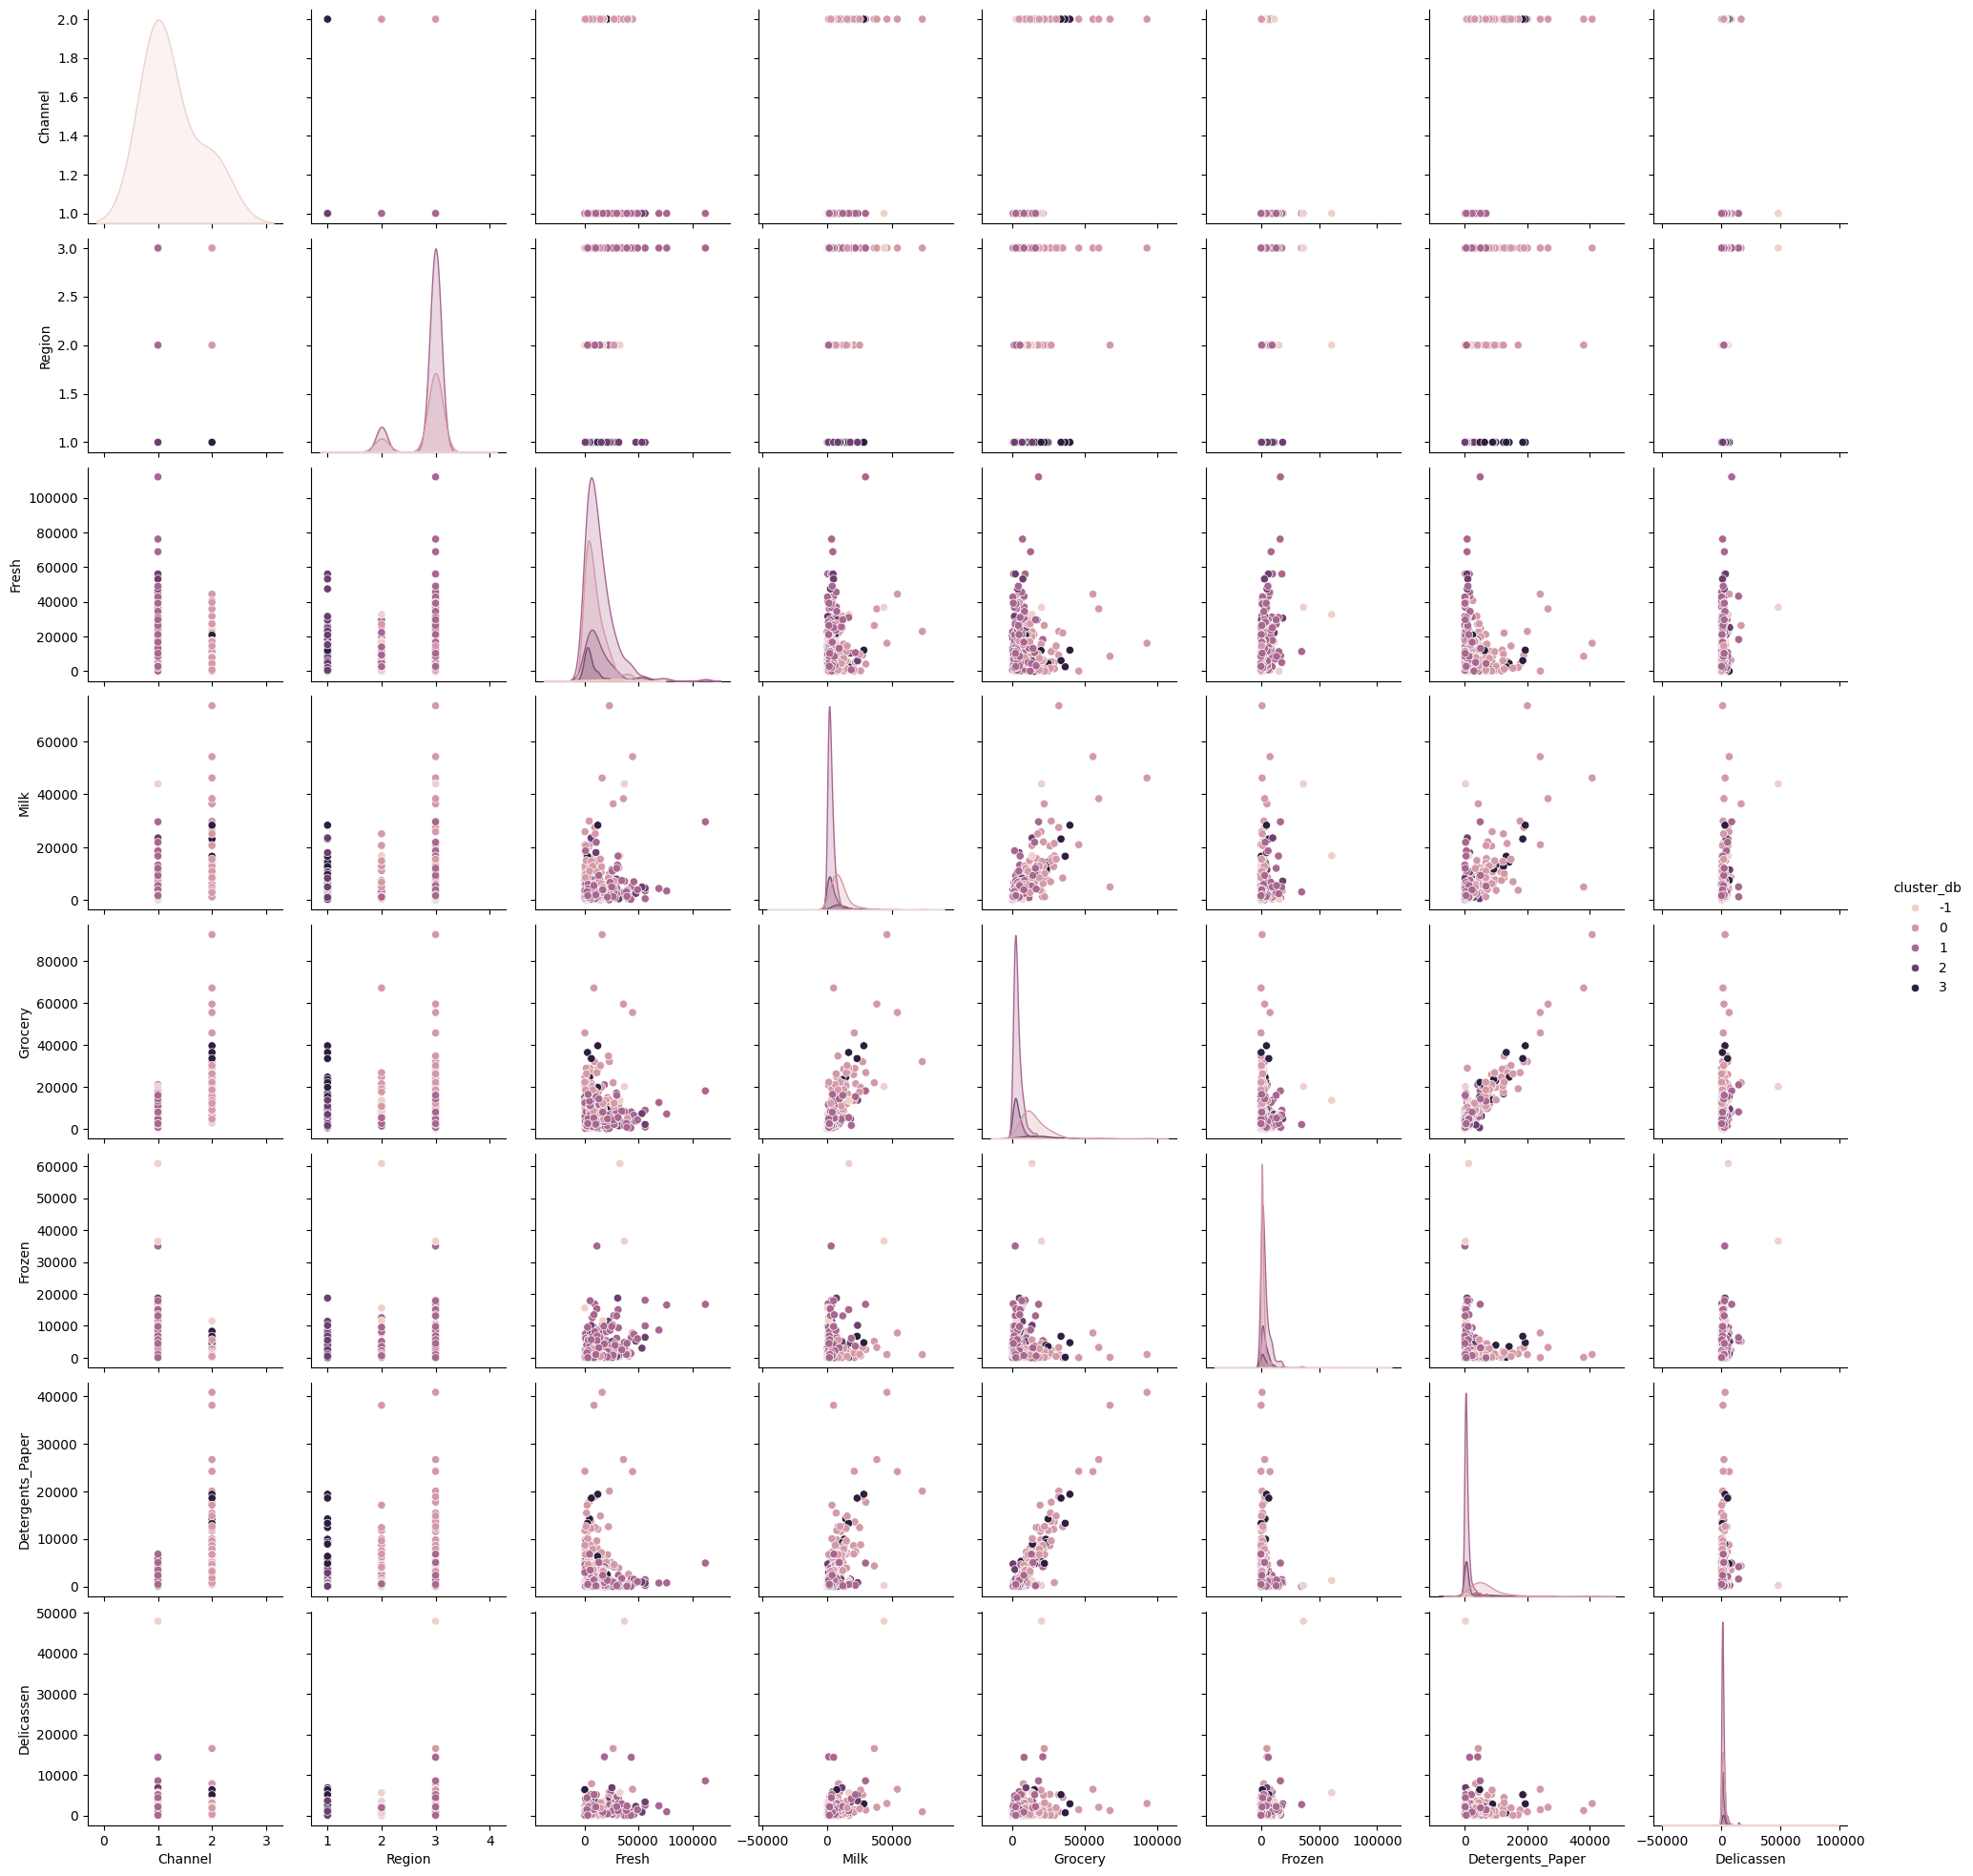

In [78]:
df0['cluster_db']=y_db
sns.pairplot(df0, hue='cluster_db');
plt.show()

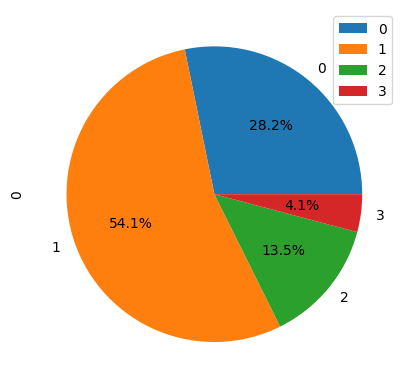

In [83]:
clust_size_db = np.unique(y_db[y_db!=-1] ,return_counts=True)
pd.DataFrame(clust_size_db[1]).plot.pie(y=0, autopct='%1.1f%%');
plt.show()

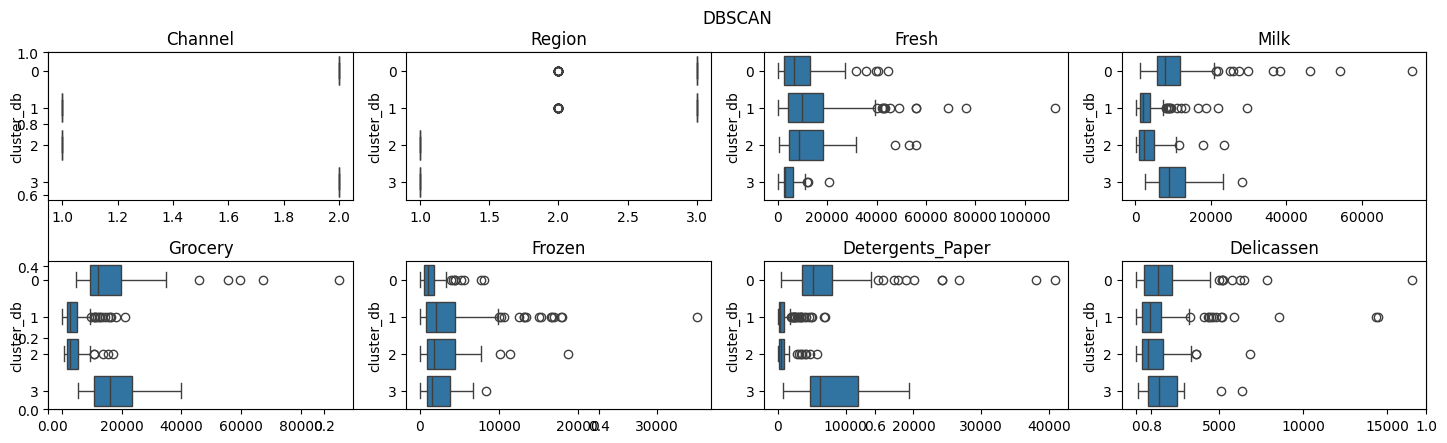

In [97]:
df0_c = df0.loc[df0['cluster_db']!=-1].copy()
plt.figure(figsize=(15,5))
plt.title('DBSCAN\n')
pos = 1
for i in df0.columns[0:8]:
    plt.subplot(2, 4, pos)
    plt.title(df0.columns[pos-1])
    plt.tight_layout()
    sns.boxplot(x=df0_c[i], y= df0_c['cluster_db'].astype('str')).set(xlabel=None)
    pos += 1
plt.show()